## Script can be used to automatically display what it thinks the best filters are

Script contains all the filters combined by MT using our filter dataset knowledge from the original ppt from QC and then using spectraview fpbase for fluorescent dyes and fluorescent protein spectra. Chroma Spectra viewer was used to extract individual chroma cube intensities, as well as a few from FP Base

### Available fluorochromes and filters

wavelength	fil_dapi_ex	fil_dapi_em	fil_orange_ex	fil_orange_em	fil_far_red_ex	fil_far_red_em	fil_custom_green_ex	fil_custom_green_em	fil_ecfp_ex	fil_ecfp_em	fil_egfp_ex	fil_egfp_em	fil_eyfp_ex	fil_eyfp_em	fil_mcherry_ex	fil_mcherry_em	fil_cy5_ex	fil_cy5_em	fil_cy3_ex	fil_cy3_em	fil_dapi_ex_new	fil_dapi_em_new	af350_em	af350_ex	af405_em	af405_ex	af430_em	af430_ex	af488_em	af488_ex	af514_em	af514_ex	af532_em	af532_ex	af546_em	af546_ex	af555_em	af555_ex	af568_em	af568_ex	af594_em	af594_ex	af610_em	af610_ex	af633_em	af633_ex	af647_em	af647_ex	af680_em	af680_ex	cy5_em	cy5_ex	dapi_em	dapi_ex	sytox_green_em	sytox_green_ex	sytox_orange_em	sytox_orange_ex	mturquoise2_em	mturquoise2_ab_ab	mturquoise2_ex	mko2_em	mko2_ex	mneongreen_em	mneongreen_ex	mcherry_em	mcherry_ex	sfgfp_em	sfgfp_ab	sfgfp_ex	mkate2_em	mkate2_ex	eyfp_em	eyfp_ex


In [1]:
# Import for libraries and color dictionary

import pandas as pd
import matplotlib.pyplot as plt
import random

color_dict = {
    'mturquoise2': 'lightblue',
    'cfp': 'blue',
    'gfp': 'lightgreen',
    'mneongreen': 'green',
    'yfp': 'yellow',
    'morange': 'orange',
    'mko2': 'darkorange',
    'mcherry': 'red',
    'rfp': 'darkred',
    'dsred': 'firebrick',
    'cy5': 'purple',
    'af647': 'indigo',
    'dapi': 'deepskyblue',
    'sfgfp': 'lime',
    'af350': 'plum',
    'af405': 'violet',
    'af430': 'darkviolet',
    'eyfp': 'yellow',
    'af488': 'limegreen',
    'af514': 'yellow',
    'af555': 'lightsalmon',
    'af568': 'coral',
    'af594': 'lightcoral',
    'sytox_green': 'darkgreen',
    'af532': 'yellow',
    'af680': 'darkred',
    'sytox_orange': 'orange',
    'af633': 'pink',  # Pink red
    'af610': 'pink',
    'mkate2': 'darkred',  # Deep red
    'af546': 'darkorange'
}


# Load the dataset
dataset = pd.read_csv(r'C:\Users\mattt\Fiji.app\Image_Analysis\Microscope_Information\filters_dyes_proteins_excitation_and_emission.csv')


In [2]:
# Function for finding best filters 

# Function to find the best matching filters for a given set of fluorophores
def find_best_matching_filters_multi(wavelength, fluorophores, filters):
    # Initialize a dictionary to store the results
    results = {}
    
    # Loop through each fluorophore to find the best match
    for fluor in fluorophores:
        # Initialize excitation and emission column names for the fluorophore
        fluorophore_ex = fluor + "_ex"
        fluorophore_em = fluor + "_em"
        
        # Initialize list to store best matching filters
        best_filters = []
        
        # Loop through each filter to find the best match
        for f in filters:
            # Calculate overlap for excitation
            ex_overlap = (wavelength * dataset[f] * dataset[fluorophore_ex]).sum()
            # Calculate overlap for emission
            em_overlap = (wavelength * dataset[f.replace('_ex', '_em')] * dataset[fluorophore_em]).sum()
            
            # Store overlap score with filter name
            best_filters.append((f.split('_')[1], ex_overlap + em_overlap))
        
        # Sort filters based on overlap score and pick the top 2
        best_filters = sorted(best_filters, key=lambda x: x[1], reverse=True)[:2]
        
        # Store the best filters for this fluorophore
        results[fluor] = best_filters
    
    # Convert results to DataFrame for better readability
    df_results = pd.DataFrame(results).T
    df_results.columns = ['Best', 'Second Best']
    
    return df_results


Top 2 Filter Sets for Each Fluorophore:
          Best Second Best
af488     egfp      custom
af594  mcherry         cy3


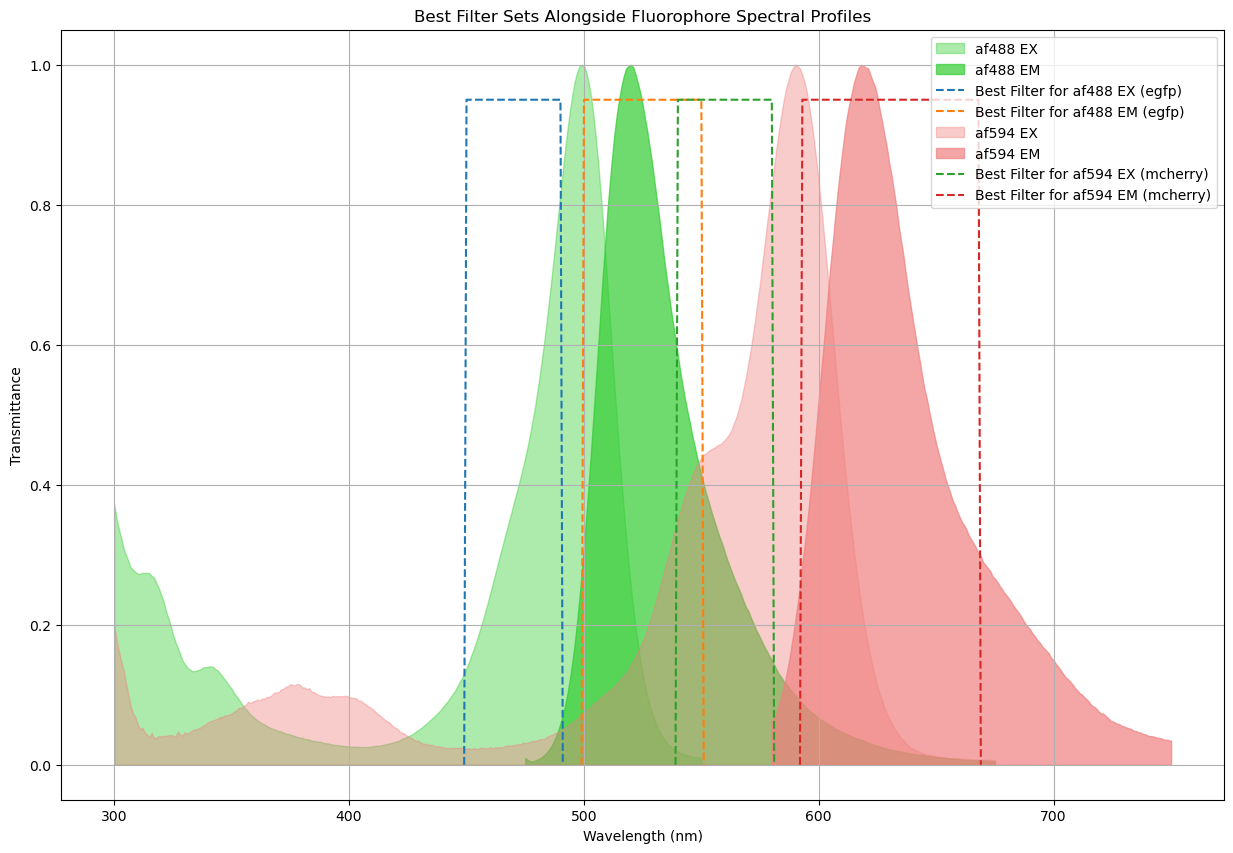

In [3]:

# Fully integrated script to analyze best filters for given fluorophores
def analyze_best_filters_for_fluorophores(fluorophores):
    # Available filter columns
    filter_columns = [col for col in dataset.columns if col.startswith('fil_')]
    
    # Filter out only the excitation filters to avoid redundancy
    ex_filter_columns = [f for f in filter_columns if '_ex' in f]
    
    # Find the best filters for each fluorophore
    best_filters_multi = find_best_matching_filters_multi(dataset['wavelength'], fluorophores, ex_filter_columns)
    
    # Print the best and second best filters for each fluorophore
    print("Top 2 Filter Sets for Each Fluorophore:")
    print(best_filters_multi.applymap(lambda x: x[0]))
    
    # Plotting to visualize the best filter sets with the fluorophores
    plt.figure(figsize=(15, 10))
    
    for fluor in fluorophores:
        # Generate random color for each fluorophore
        fluor_color = color_dict.get(fluor.lower(), 'grey')  # Get the color from the dictionary, default to grey if not found
        
        # Plot excitation and emission profiles for each fluorophore
        plt.fill_between(dataset['wavelength'], dataset[fluor + '_ex'], color=fluor_color, alpha=0.4, label=f'{fluor} EX')
        plt.fill_between(dataset['wavelength'], dataset[fluor + '_em'], color=fluor_color, alpha=0.7, label=f'{fluor} EM')
        
        # Plot the best filter set for each fluorophore
        best_filter = best_filters_multi.loc[fluor, 'Best'][0]
        plt.plot(dataset['wavelength'], dataset[f'fil_{best_filter}_ex'], '--', label=f'Best Filter for {fluor} EX ({best_filter})')
        plt.plot(dataset['wavelength'], dataset[f'fil_{best_filter}_em'], '--', label=f'Best Filter for {fluor} EM ({best_filter})')
    
    plt.title('Best Filter Sets Alongside Fluorophore Spectral Profiles')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmittance')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.show()

# Test the script with example fluorophores
analyze_best_filters_for_fluorophores(['af488', 'af594'])




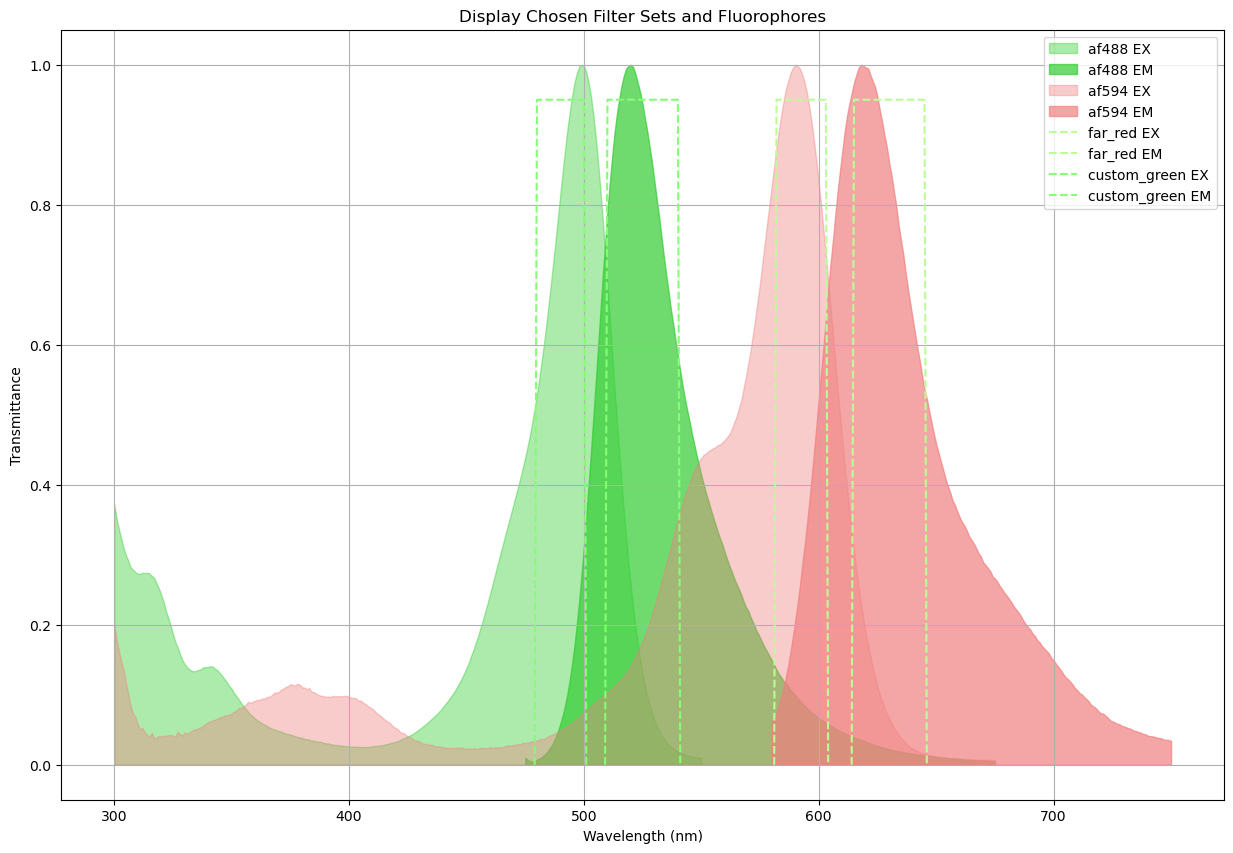

In [4]:
# Adapted function for direct selection and visualization

# Function to generate a random color
def random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])

#Function for plot 
def plot_custom_filters_and_fluorophores(fil_input, fluor_input):
    plt.figure(figsize=(15, 10))
    
    # Loop through each given fluorophore to plot its excitation and emission profiles
    for fluor in fluor_input:
        fluor_color = color_dict.get(fluor.lower(), 'grey')  # Get the color from the dictionary, default to grey if not found
        plt.fill_between(dataset['wavelength'], dataset[fluor + '_ex'], color=fluor_color, alpha=0.4, label=f'{fluor} EX')
        plt.fill_between(dataset['wavelength'], dataset[fluor + '_em'], color=fluor_color, alpha=0.7, label=f'{fluor} EM')
    
    # Loop through each given filter set to plot its excitation and emission profiles
    for fil in fil_input:
        random_fil_color = random_color()  # Generate a random color for each filter
        plt.plot(dataset['wavelength'], dataset['fil_' + fil + '_ex'], '--', color=random_fil_color, label=f'{fil} EX')
        plt.plot(dataset['wavelength'], dataset['fil_' + fil + '_em'], '--', color=random_fil_color, label=f'{fil} EM')
    
    # Configure the plot
    plt.title('Display Chosen Filter Sets and Fluorophores')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmittance')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Test the function with example inputs
plot_custom_filters_and_fluorophores(['far_red', 'custom_green'], ['af488', 'af594'])


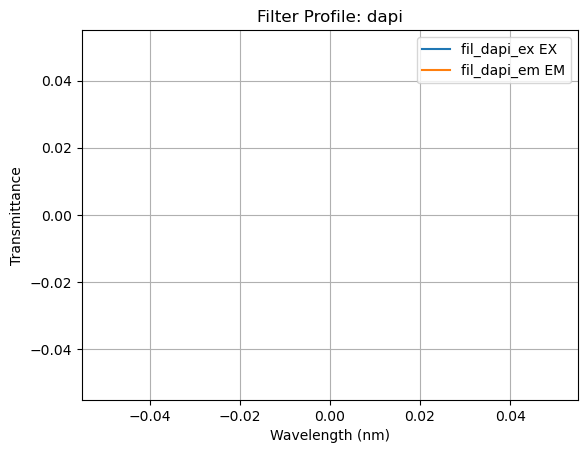

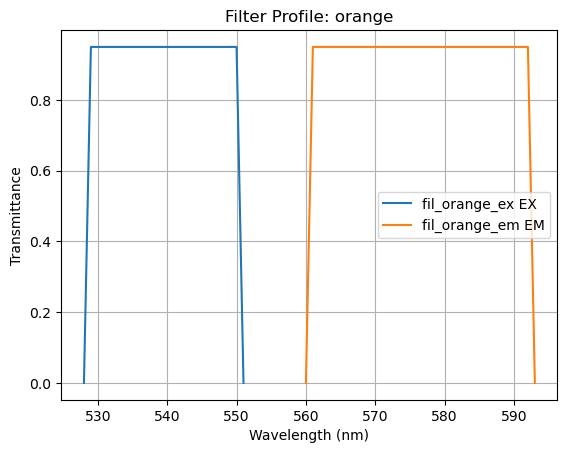

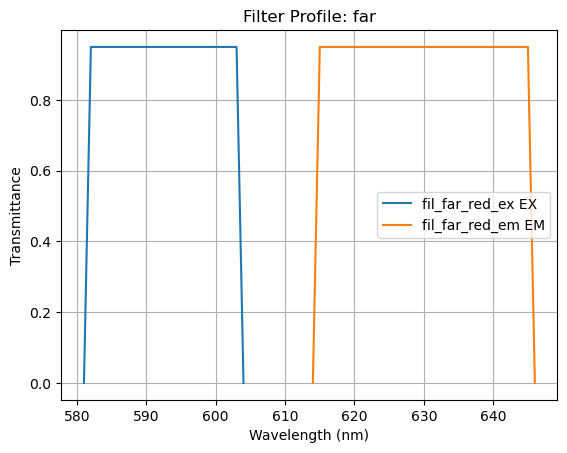

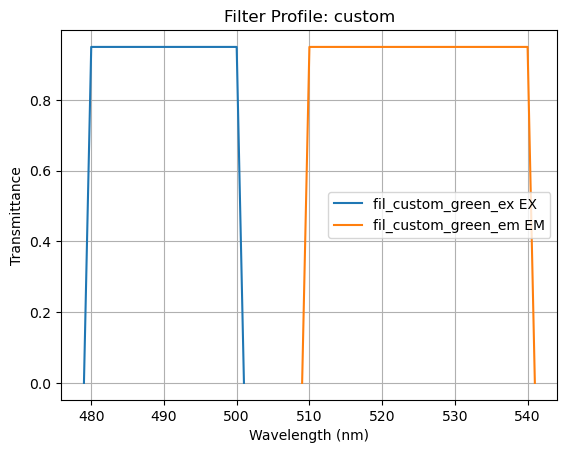

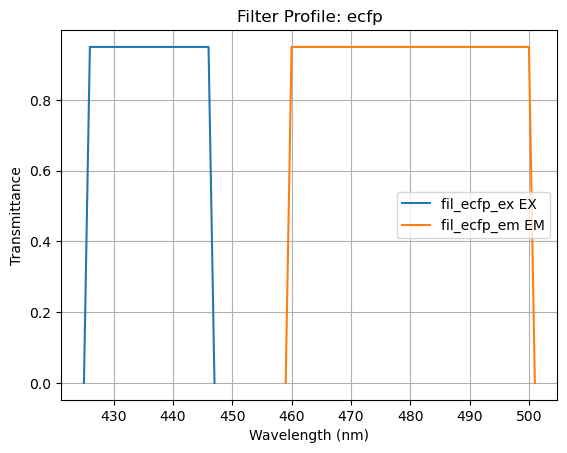

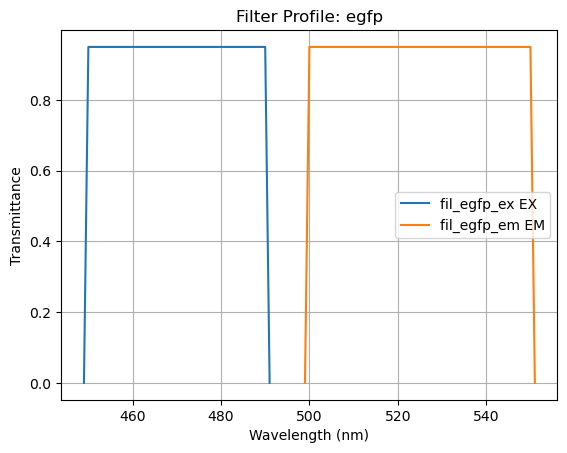

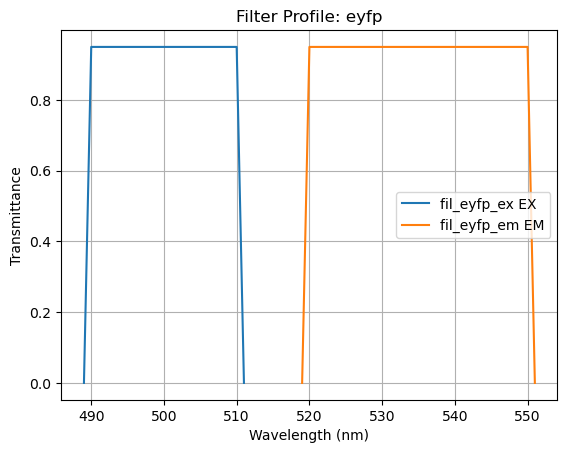

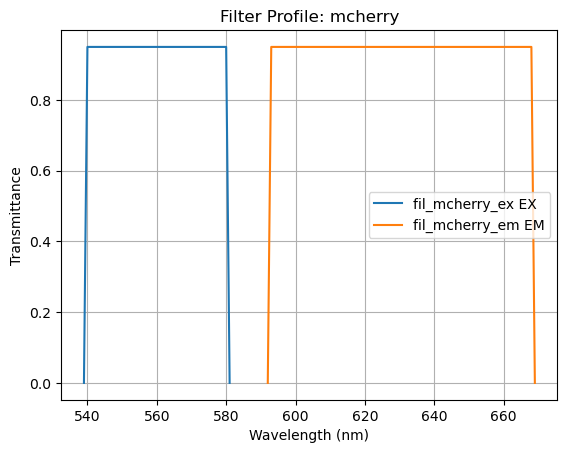

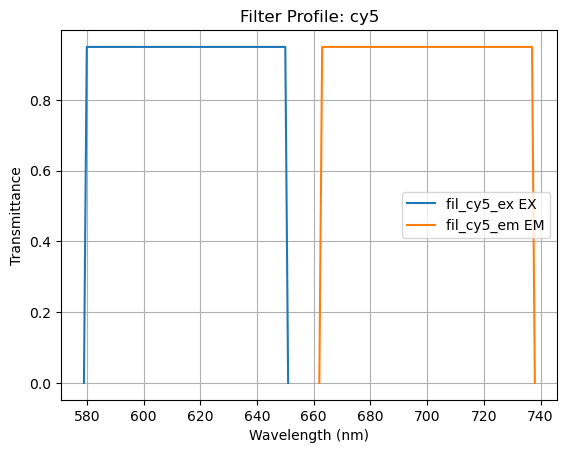

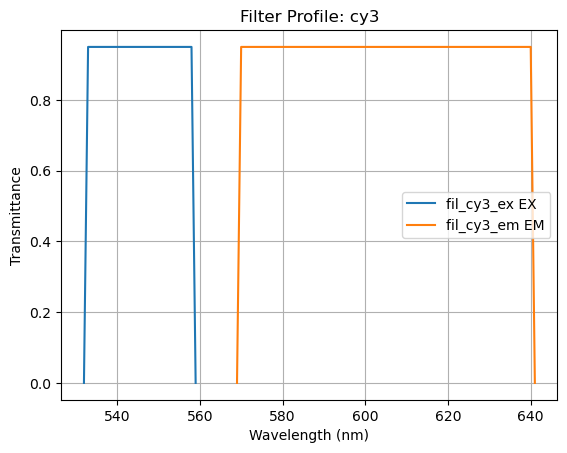

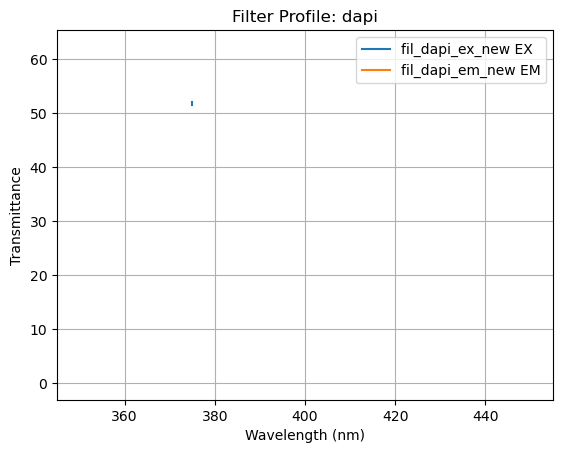

In [5]:
# Function to plot and save individual filter profiles
def plot_individual_filters(dataset):
    filter_columns = [col for col in dataset.columns if col.startswith('fil_') and '_ex' in col]
    
    for filter_col in filter_columns:
        plt.figure()
        plt.plot(dataset['wavelength'], dataset[filter_col], label=f'{filter_col} EX')
        plt.plot(dataset['wavelength'], dataset[filter_col.replace('_ex', '_em')], label=f'{filter_col.replace("_ex", "_em")} EM')
        plt.title(f'Filter Profile: {filter_col.split("_")[1]}')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Transmittance')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'C:/Users/mattt/Fiji.app/Image_Analysis/Microscope_Information/Fluorophore_plots/_{filter_col.split("_")[1]}.png')
        plt.show()
        
        # Run the functions
plot_individual_filters(dataset)



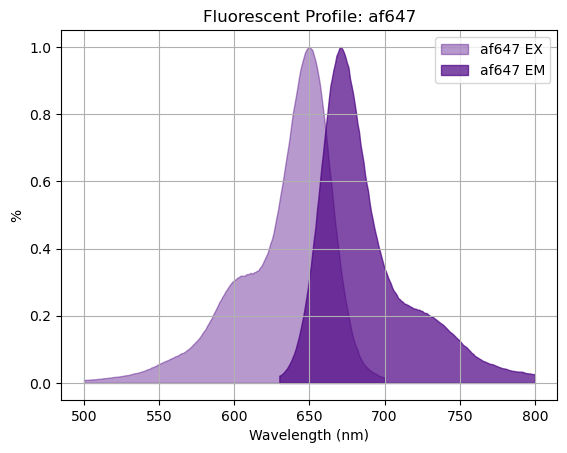

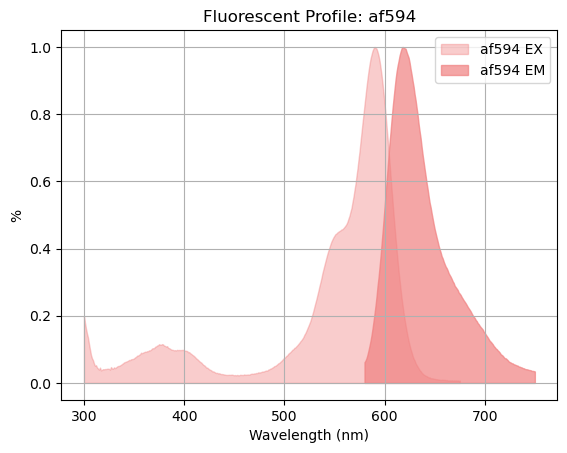

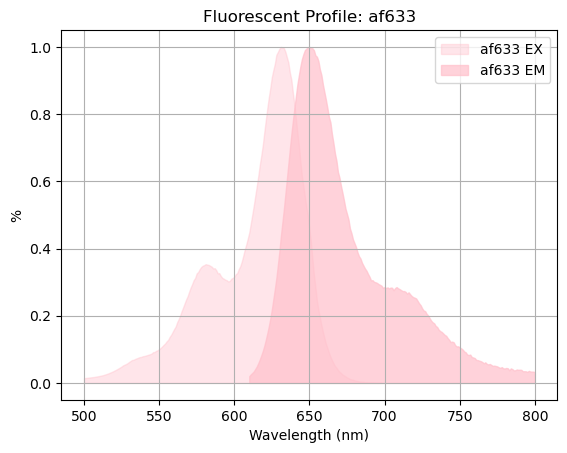

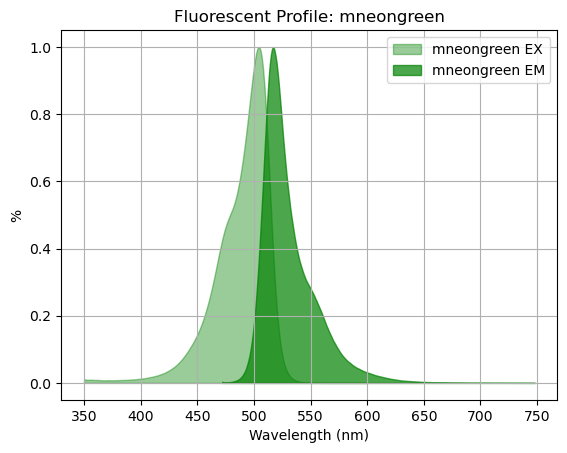

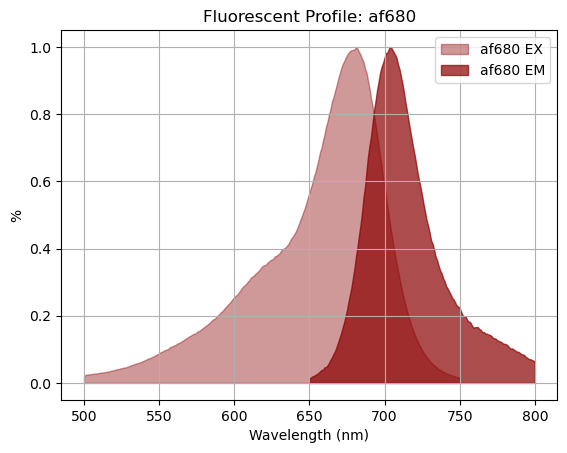

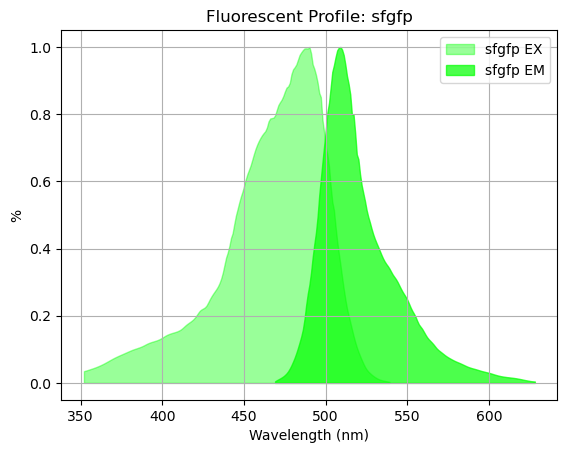

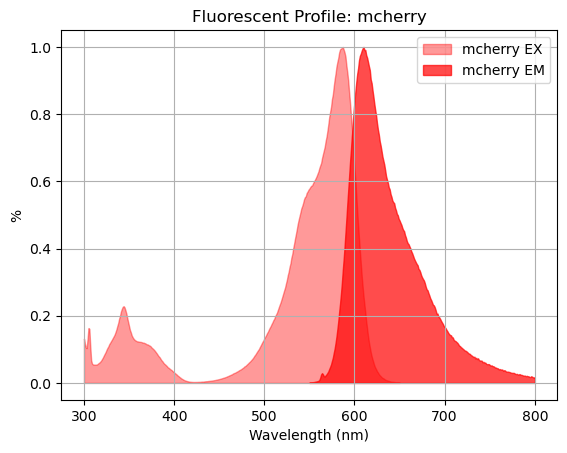

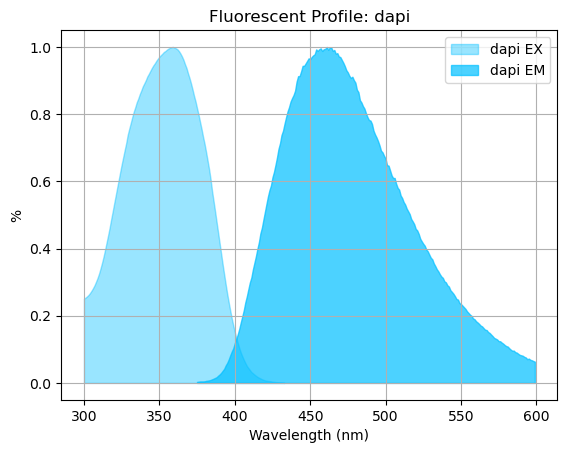

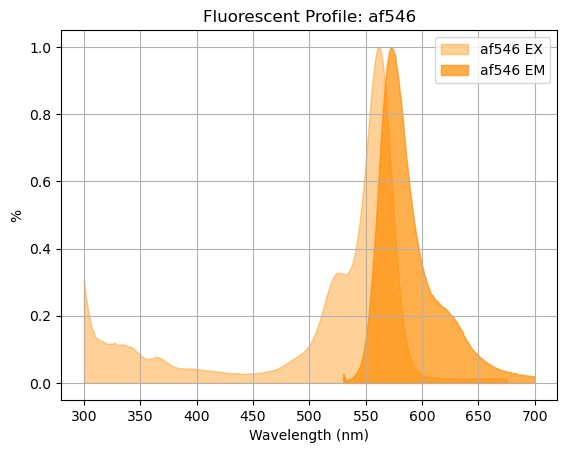

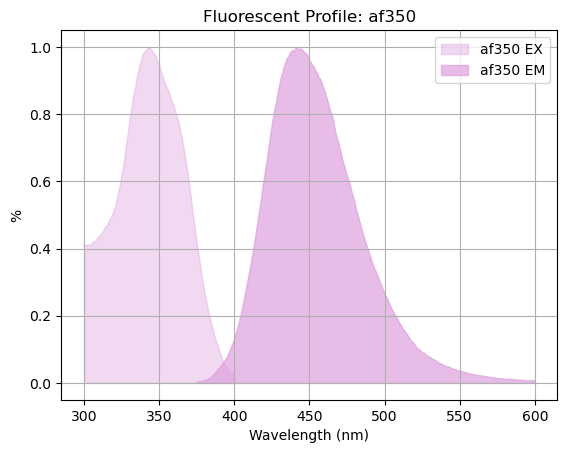

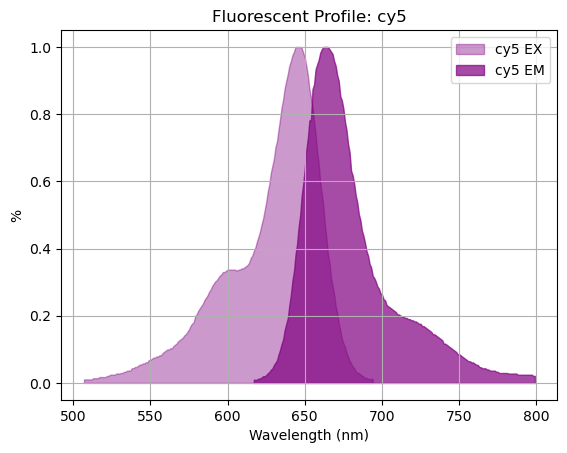

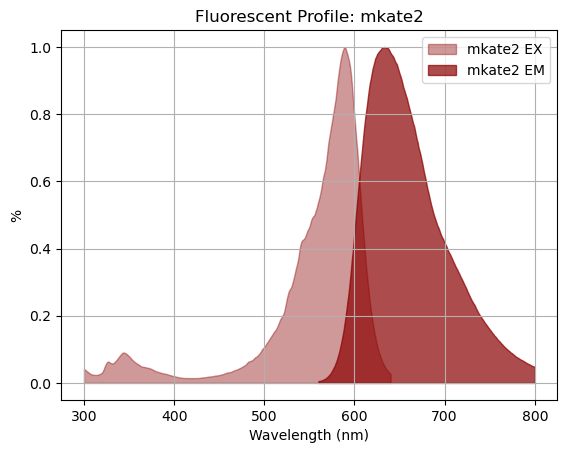

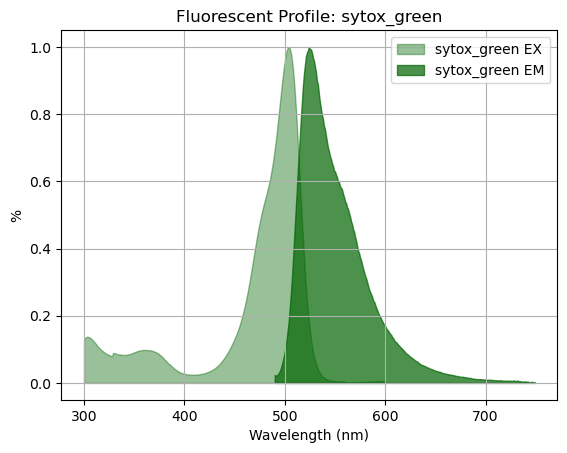

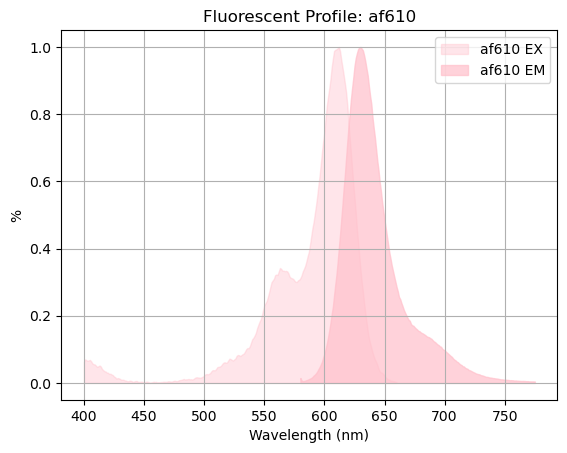

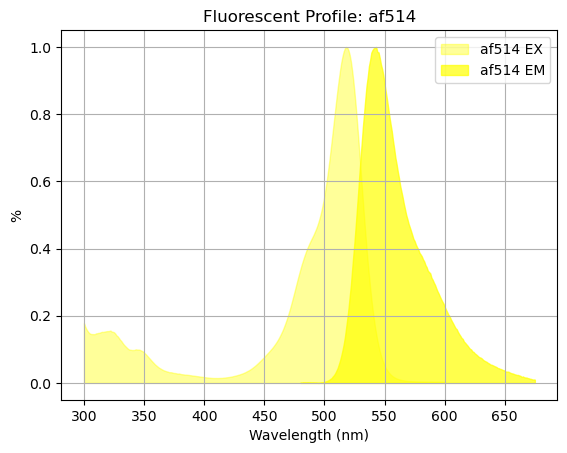

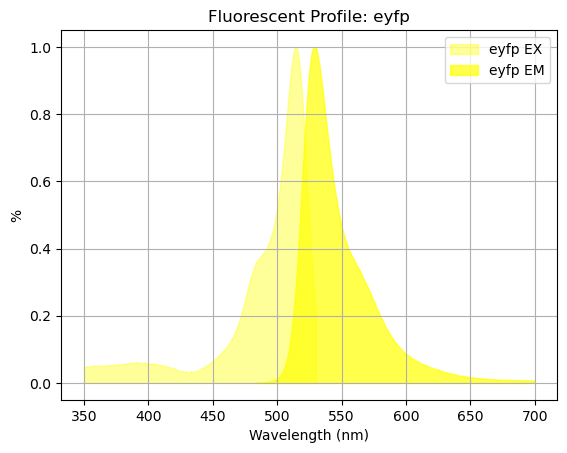

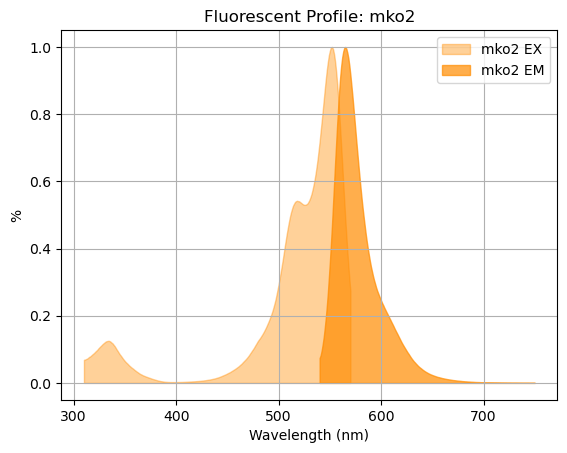

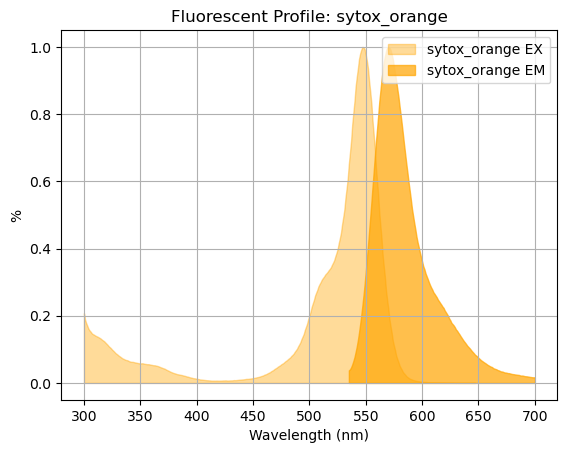

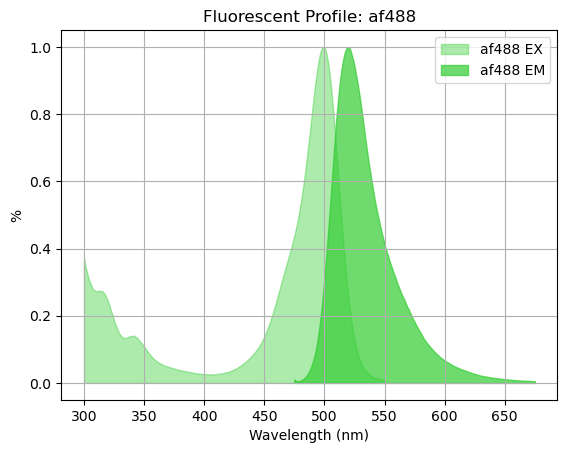

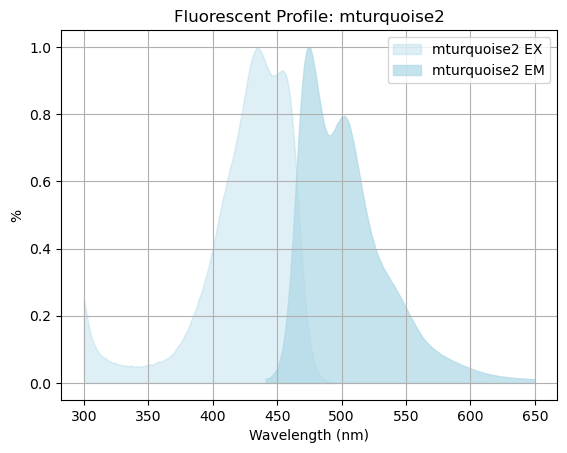

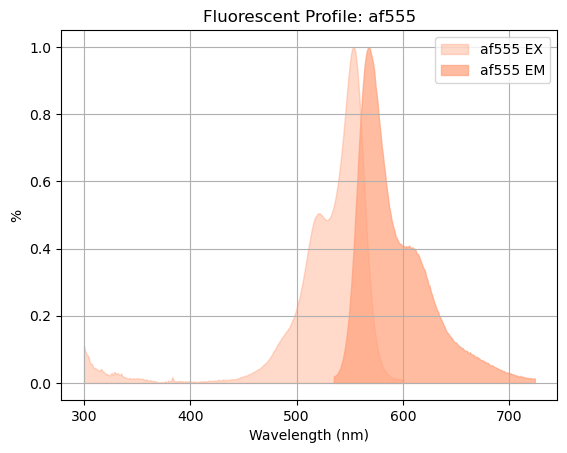

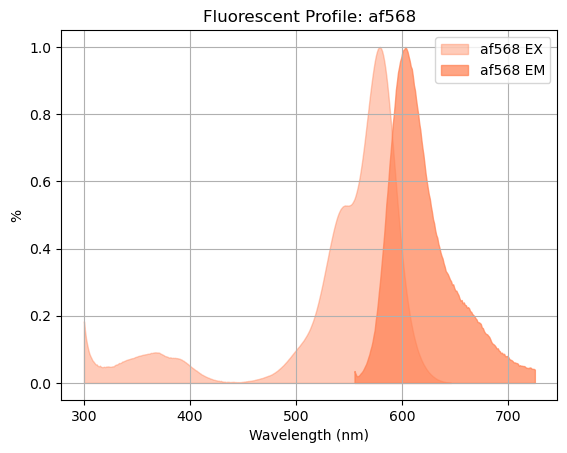

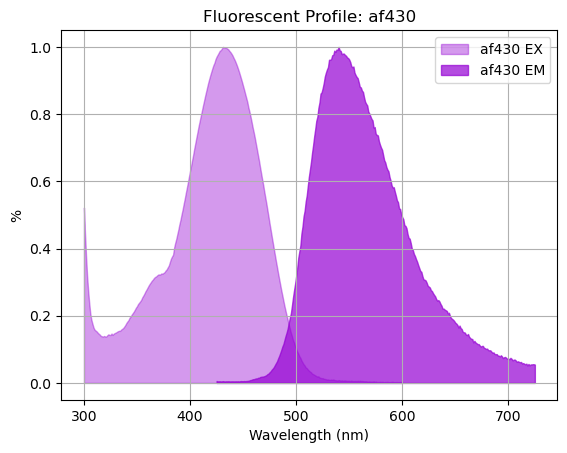

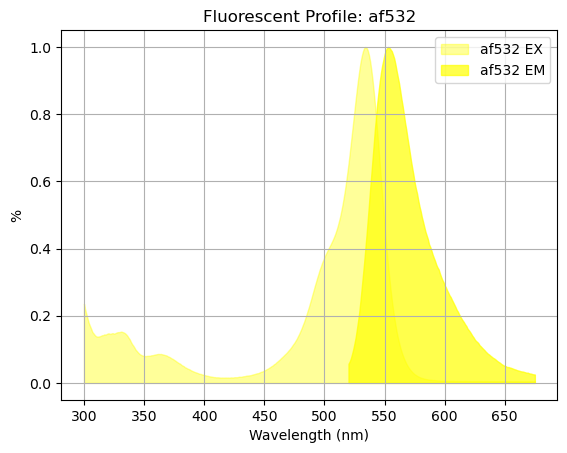

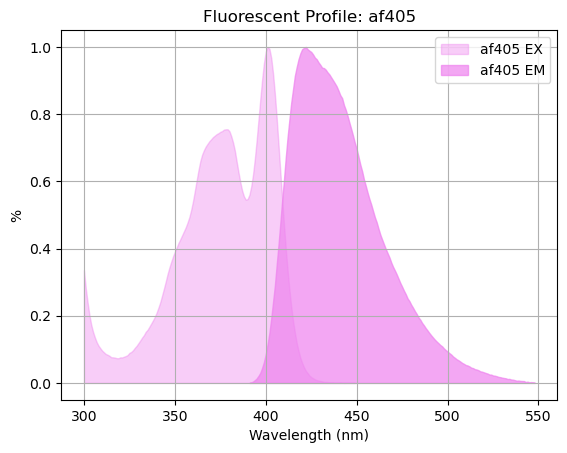

In [6]:


# Function to plot and save individual fluorophore profiles
def plot_individual_fluorophores(dataset):
    fluorophore_columns = set(col.rsplit('_', 1)[0] for col in dataset.columns if not col.startswith('fil_') and not col == 'wavelength')
    
    for fluor in fluorophore_columns:
        color = color_dict.get(fluor.lower(), 'grey')  # Default to grey if color not found in dictionary
        
        plt.figure()
        plt.fill_between(dataset['wavelength'], dataset[f'{fluor}_ex'], alpha=0.4, label=f'{fluor} EX', color=color)
        plt.fill_between(dataset['wavelength'], dataset[f'{fluor}_em'], alpha=0.7, label=f'{fluor} EM', color=color)
        plt.title(f'Fluorescent Profile: {fluor}')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('%')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'C:/Users/mattt/Fiji.app/Image_Analysis/Microscope_Information/Fluorophore_plots/Fluorophore_Profile_{fluor}.png')
        plt.show()


plot_individual_fluorophores(dataset)
